# DEMO FOR NEURAL STYLE TRANSFER

---

Resources:

- Ambient sounds (free downloads):
    - https://mixkit.co/free-sound-effects/
    - https://pixabay.com/sound-effects/
- Music pieces (royalty free): https://www.chosic.com/free-music/

---

Importing custom functions and predefined imports...

In [4]:
import import_ipynb
N = import_ipynb.NotebookLoader(path=['.'])
N.load_module("ImportsForNeuralStyleTransfer")
from ImportsForNeuralStyleTransfer import *

importing Jupyter notebook from .\ImportsForNeuralStyleTransfer.ipynb
importing Jupyter notebook from genreClassification\ImportsForAudioHandling.ipynb
importing Jupyter notebook from genreClassification\ImportsForModelHandling.ipynb


# Important constants and variables

In [29]:
all_file_names = get_file_names('AUDIO')
# NOTE: `get_file_names` defined in `genreClassification/ImportsForAudioHandling.ipynb`

# Segregating audio based on content and style tags:
all_content_names, all_style_names = [], []
for file_name in all_file_names:
    if 'CONTENT' in file_name:
        all_content_names.append(file_name)  
    elif 'STYLE' in file_name:
        all_style_names.append(file_name)  

audioDataHandler = AudioDataHandler(
    content_path='audio',
    style_path='audio',
    sr=22050,
    n_fft=1024,
    hop_length=256,
    segment_size=431,
    n_mels=384,
    n_mfcc=40)

**Explaining the audio parameters**...

_Number of mel bands, sampling rate, hop length and FFT window size_... <br>
The CNN model for genre classification was trained for sampling rate 22050 Hz (since the training data's audio was also sampled at this rate), with hop length (`hop_length`) 256 and FFT window length (`n_fft)` 1024. These parameters were chosen based on the results of some trials I performed for audio parameters, where I arrived at sampling rate 44100 Hz to be sufficiently high for good quality audio sampling in general, along with hop length 512 and FFT window lwngth 2048 as sufficient to allow for the reconversion of melspectrograms generated from the audio back to good quality audio signals. Notice that in training, I simply halved each parameter such that each segment of my 44100 Hz melspectrograms will cover the same length of the audio as each segment of the 22050 Hz melspectrograms used for training the model.

_Number of MFCCs_... <br>
Where I shall use MFCCs, there I shall not use melspectrograms, since these are separate kinds of audio data. However, in case I want to use MFCCs, I have included this parameter. There are separate CNNs trained for MFCCs and melspectrograms respectively, and I wanted to be able to use either or both kinds of audio data as needed. The number of MFCCs was determined by trail-and-error by checking which values led to more accuracy genre classifications and sufficiently fast and stable convergence during training.

_Number of frames per audio data array (melspectrogram or MFCCs-per-frame array)_... <br>
The number of frames per segment `segment_size` is the same number of frames as the segmented audio data used in training the respective CNN (remember that separate CNNs were trained for both MFCCs and melspectrograms). Segmenting my own audio data such that each is `segment_size` in length allows me to input the audio data into the model's layers.

---

**NOTE** Defining the full preprocessing pipeline is defined in `ImportsForNeuralStyleTransfer.ipynb` in the function `get_segments`.

<h1 style="color:blue"> DEMO: Obtaining style and content images </h1>

In [30]:
content_name = all_content_names[0]
style_name = all_style_names[0]

# Getting the time-domain signals:
content_signal = audioDataHandler.get_signal(audio_path=audioDataHandler.content_path, audio_name=content_name)
style_signal = audioDataHandler.get_signal(audio_path=audioDataHandler.style_path, audio_name=style_name)

# Getting the melspectrograms:
style_melspectrogram = audioDataHandler.get_melspectrogram(style_signal)
content_melspectrogram = audioDataHandler.get_melspectrogram(content_signal)

**NOTE**: _384 mel bands are used since this number of mel bands was found to be a high-resolution enough to convert back to a sufficiently high-quality audio signal._

---

Visualising melspectrograms for getting an intuitive idea about the audio involved...

**NOTE**: _I am converting signal power from amplitude to decibel scale (which is a logarithmic scale), which allows us to see the frequencies more relevant to human perception. But this is for visualisation only, as it is harder to reconstruct the original audio signal from a decibel-scaled melspectrogram._

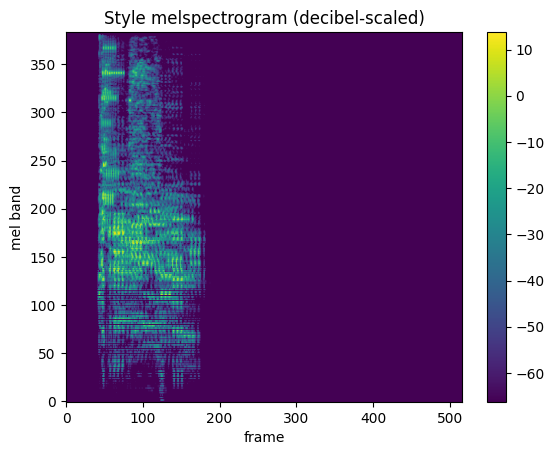

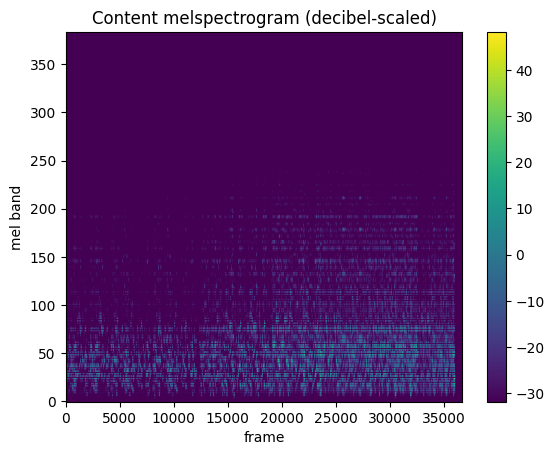

In [31]:
audioDataHandler.visualise(librosa.amplitude_to_db(style_melspectrogram), title='Style melspectrogram (decibel-scaled)', ylabel='mel band')
audioDataHandler.visualise(librosa.amplitude_to_db(content_melspectrogram), title='Content melspectrogram (decibel-scaled)', ylabel='mel band')

We can see that the melspectrograms are not equally sized. Furthermore, in the CNN trained for genre classification, the input consisted of melspectrograms of 5-second long segments of audio (the segmentation was done to augment training data and improve model accuracy in general), which had `audio_params['segment_size']` frames each (given a sampling rate of 22050 Hz). Hence, we shall divide each of the melspectrograms obtained for the style and content `audio_params['segment_size']` frames-long segments...

In [32]:
# Dividing the array of style MFCCs into equally-sized segments:
segment_size = audioDataHandler.segment_size # Renaming for convenience

# Dividing the content into equally-sized segments:
content_segments = []
for i in range(int(content_melspectrogram.shape[1]/segment_size)):
    content_segments.append(content_melspectrogram[:, i*segment_size:(i+1)*segment_size])
content_segments = np.array(content_segments) # Converting to an array for ease of handling and storing
print('Shape of segmented content melspectrogram data:', content_segments.shape)

style_segments = []
for i in range(int(style_melspectrogram.shape[1]/segment_size)):
    style_segments.append(style_melspectrogram[:, i*segment_size:(i+1)*segment_size])
style_segments = np.array(style_segments) # Converting to an array for ease of handling and storing
print('Shape of segmented style melspectrogram data:', style_segments.shape)

Shape of segmented content melspectrogram data: (85, 384, 431)
Shape of segmented style melspectrogram data: (1, 384, 431)


# Initialising the pretrained model
Calling function to generate CNN model (function defined in `ImportsForModelBuilding.ipynb`) and viewing model parameters...

In [33]:
# Initialising model:
model = get_cnn_5_sec_melspectrogram(input_shape=(audioDataHandler.n_mels, audioDataHandler.segment_size, 1), lr=0.01)
# Loading pretrained weights:
load_model(model, 'genreClassification/storage/trainedModelWeights/genreClassificationTrainedModelWeights_sr-22050_n_fft-1024_hop_length-256_n_mels-384_bestValidationAccuracy.npy')
# Viewing model summary:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ identity_1 (Identity)                │ (None, 384, 431, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 384, 431, 1)         │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 383, 430, 32)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 192, 215, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 191, 214, 32)        │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 96, 107, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 95, 106, 32)         │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 48, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 47, 52, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 24, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 23, 25, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 12, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 11, 12, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 5, 5, 32)            │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 4, 4, 32)            │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 62,670 (244.80 KB)

 Trainable params: 62,604 (244.55 KB)

 Non-trainable params: 66 (264.00 B)

<h2 style="color:blue"> DEMO: Predicting genre using the model </h2>
Testing the predictive power of our genre classifier...

In [34]:
content_name = np.random.choice(all_content_names)
style_name = np.random.choice(all_style_names)
print(f'Content file chosen: {content_name}')

content_segments, style_segments = audioDataHandler.get_segments(content_name, style_name)
get_predictions_summary(model, content_segments, return_value=False)

Content file chosen: CONTENT - Bach - Goldberg Variations BWV 988 - Aria - Aaron Dunn - Chosic.mp3
Proportion of total predictions for class "classical" = 0.6071428571428571
Proportion of total predictions for class "jazz" = 0.39285714285714285


Reconstructing the audio signal to verify auditorily...

In [35]:
audioDataHandler.reconstruct_signal_from_melspectrogram_segments_and_play(content_segments[:5], return_value=False)
# Including only 5 segments for computational ease

# Preparing for neural style transfer

> REFERENCES:
> - https://medium.com/@ferlatti.aldo/neural-style-transfer-nst-theory-and-implementation-c26728cf969d
> - https://arxiv.org/pdf/1508.06576.pdf

**NOTE**: All the following code has been encapsulated in objects and functions in `ImportsForNeuralStyleTransfer.ipynb`.

## Obtaining layer-wise outputs
We want to use the convolutional layers of our pretrained model to study and use the features extracted by each layer to help model content and style and thus obtain content and style loss (which is necessary for neural style transfer).

---

Defining a dictionary relating each layer name to the layer's tensor of weights...

In [36]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print('MODEL LAYERS')
for key in outputs_dict: print(f'{key}: {outputs_dict[key]}')

MODEL LAYERS
identity_1: <KerasTensor shape=(None, 384, 431, 1), dtype=float32, sparse=None, name=keras_tensor_25>
batch_normalization_2: <KerasTensor shape=(None, 384, 431, 1), dtype=float32, sparse=False, name=keras_tensor_26>
conv2d_8: <KerasTensor shape=(None, 383, 430, 32), dtype=float32, sparse=False, name=keras_tensor_27>
max_pooling2d_8: <KerasTensor shape=(None, 192, 215, 32), dtype=float32, sparse=False, name=keras_tensor_28>
conv2d_9: <KerasTensor shape=(None, 191, 214, 32), dtype=float32, sparse=False, name=keras_tensor_29>
max_pooling2d_9: <KerasTensor shape=(None, 96, 107, 32), dtype=float32, sparse=False, name=keras_tensor_30>
conv2d_10: <KerasTensor shape=(None, 95, 106, 32), dtype=float32, sparse=False, name=keras_tensor_31>
max_pooling2d_10: <KerasTensor shape=(None, 48, 53, 32), dtype=float32, sparse=False, name=keras_tensor_32>
conv2d_11: <KerasTensor shape=(None, 47, 52, 32), dtype=float32, sparse=False, name=keras_tensor_33>
max_pooling2d_11: <KerasTensor shape=(N

---

Creating a model that returns layer-wise outputs for given input(s)...

**NOTE**: _The input shape is the same as our pretrained model._

In [37]:
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

---

Testing the above for an array of 2 content melspectrogram segment...

In [38]:
outputs = feature_extractor(content_segments[:2])

print('OUTPUT SHAPES FOR EACH LAYER')
for key in outputs: print(f'{key}: {outputs[key].shape}')

OUTPUT SHAPES FOR EACH LAYER
identity_1: (2, 384, 431, 1)
batch_normalization_2: (2, 384, 431, 1)
conv2d_8: (2, 383, 430, 32)
max_pooling2d_8: (2, 192, 215, 32)
conv2d_9: (2, 191, 214, 32)
max_pooling2d_9: (2, 96, 107, 32)
conv2d_10: (2, 95, 106, 32)
max_pooling2d_10: (2, 48, 53, 32)
conv2d_11: (2, 47, 52, 32)
max_pooling2d_11: (2, 24, 26, 32)
conv2d_12: (2, 23, 25, 32)
max_pooling2d_12: (2, 12, 13, 32)
conv2d_13: (2, 11, 12, 32)
max_pooling2d_13: (2, 6, 6, 32)
conv2d_14: (2, 5, 5, 32)
max_pooling2d_14: (2, 5, 5, 32)
conv2d_15: (2, 4, 4, 32)
max_pooling2d_15: (2, 4, 4, 32)
batch_normalization_3: (2, 4, 4, 32)
dropout_1: (2, 4, 4, 32)
flatten_1: (2, 512)
dense_2: (2, 64)
dense_3: (2, 10)


An example output (last layer)...

In [39]:
print(f'OUTPUT FOR LAYER "{list(outputs.keys())[-1]}"')
print(outputs[list(outputs.keys())[-1]].numpy())

OUTPUT FOR LAYER "dense_3"
[[5.0153840e-08 9.9313778e-01 1.2507285e-05 3.5691868e-05 2.9704846e-05
  6.4340038e-03 4.9680521e-06 1.4304578e-04 5.5850251e-05 1.4633554e-04]
 [3.5191499e-07 9.7866666e-01 3.4298839e-05 5.7219851e-05 5.7741494e-05
  2.0486394e-02 8.3163877e-06 2.8400955e-04 1.2846330e-04 2.7662865e-04]]


## Defining Gram matrix

> REFERENCES:
> - https://youtu.be/AJOyMJjPDtE?si=O93uiOPtax5074Rx
> - https://inst.eecs.berkeley.edu/~ee127/sp21/livebook/def_Gram_matrix.html

---

A Gram matrix of a set of feature vectors is essentially the matrix holding the dot products between every pair of feature vectors of the same layer (note that a feature vector is the flattened array of the result of applying a filter in a convolutional layer to the input matrix). Hence, a Gram matrix is a means to study the co-occurrence of the two features; a high entry in a specific position in the Gram matrix means the two features have a high dot product, which in turn means occur in high quantities together in that specific position (e.g. green colour appearing in high quantities together with a certain shape). Such co-occurrence gives us a means to study the style, i.e. the way the features of the input interact with each other. Mathematically, a Gram matrix $G$ for a set of vectors $a_1, a_2 ... a_k$ is a matrix such that:

$G_{ij} = a_i \cdot a_j = a_i a_j^T$ (assuming each is a row vector, which is the default in array operations)

To explain the last term, note that the dot product between two vectors is equal to the matrix multiplication between one vector and the transpose of the other vector such that a single scalar is obtained (in the case of row vectors, we transpose the second vector, while in the case of column vectors, we transpose the first vector). Hence, we can condense the calculation of a Gram matrix as:

$G = (a_1, a_2 ... a_k) (a_1^T, a_2 ... a_k^T)^T$

Hence, to obtain the Gram matrix for a given layer (i.e. for the set of feature vectors of the given layer), we need to:

1. Flatten each layer output to obtain the feature vectors
2. Define a tensor $A$ containing each feature vector
3. Define a tensor $B$ containing the transpose of each feature vector (in matching order)
4. Obtain $A B^T$

**REMEMBER**: _A feature vector is the flattened array of the layer output, i.e. of the result of applying a filter to the layer input._

In [40]:
def get_gram_matrix(layer_outputs):
    # 1. Flatten each layer output to obtain the feature vectors:
    layer_outputs = tf.transpose(layer_outputs, (3, 0, 1, 2)) # What is this for? See the text box below this code box
    layer_outputs = tf.reshape(layer_outputs, (tf.shape(layer_outputs)[0], -1))
    
    # 2. Defining a tensor A containing each feature vector:
    # We already have `layer_outputs`

    # 3. Define a tensor B containing the transpose of each feature vector (in matching order):
    '''
    For this, we can simply do `tf.transpose(layer_outputs)`.
    Such an application of `tf.transpose` will reverse the dimensionality of `layer_outputs`.
    This not only transposes the outer tensor but every feature vector within as well.
    Hence, this obtains B^T.
    '''

    # 4. Obtain AB^T (see previous comment):
    gram_matrix = tf.matmul(layer_outputs, tf.transpose(layer_outputs))
    # NOTE: `tf.matmul` performs matrix multiplication
    return gram_matrix

**IMPLEMENTATION NOTE: Why transpose layer outputs before obtaining feature vectors?**:

**_Here, we assume the layer is a convolutional layer._**

The Gram matrix must relate each feature of the layer to every other feature of the layer. Hence, our layer outputs (before obtaining feature vectors) must be in the form:

`<filter 1 output>, <filter 1 output> ... <filter k output>`

_Note that "filter" here is synonymous to "channel" or "feature"; the application of a filter to the layer's input results in a feature_. Now, look at the way the layer output of a particular convolutional (_taken as an example; the same principle applies for all convolutional layers_) is actually shaped...

In [41]:
layer_outputs = feature_extractor(content_segments[:4])[list(outputs_dict.keys())[1]] # Using the 1st convolutional layer
print('Convolutional layer output shape:', layer_outputs.shape)

Convolutional layer output shape: (4, 384, 431, 1)


Note that each convolutional layer has 32 channels. Furthermore, we have passed 4 segments to the layer where each segment is a 2D array (originally a melspectrogram). Hence, the shape of the layer's output is of the form:

`<number of segments>, <height>, <width>, <number of filters>`

But, we want it to be of the form:

`<filter 1 output>, <filter 1 output> ... <filter k output>`

Hence, must ensure that the shape is of the form:

`<number of filters>, <number of segments>, <height>, <width>`

In other terms, we ensure that the filter output is an array contained in an array of filter outputs. Hence, we transpose the layer outputs as follows:

In [42]:
layer_outputs = tf.transpose(layer_outputs, perm=(3, 0, 1, 2))
print('Convolutional layer output shape after transposing:', layer_outputs.shape)

Convolutional layer output shape after transposing: (1, 4, 384, 431)


## Defining content loss, style loss and total loss with gradient
**NOTE**: _We want the return values of each loss function to be a Tensorflow tensor so that it is easier to calculate the loss gradient using in-built Tensorflow functions. Check the implementation note at the end of this section for more information._

**_Each of the following has been implemented slightly differently but essentially in the same way in_** `ImportsForNeuralStyleTransfer.ipynb`.

In [43]:
def get_content_loss(layer_output_for_content, layer_output_for_target):
    n1, n2, n3, n4 = layer_output_for_target.shape
    
    # Returning mean squared errors between layer outputs:
    return tf.reduce_sum(tf.square(layer_output_for_content-layer_output_for_target))/(n1*n2*n3*n4)
    # NOTE: We want to preserve the `tf.tensor` datatype
    
#================================================
def get_style_loss(layer_output_for_style, layer_output_for_target):
    n1, n2, n3, n4 = layer_output_for_target.shape
    
    # Obtaining Gram matrices:
    gram_matrix_target = get_gram_matrix(layer_output_for_target) # Gram matrix for the target image
    gram_matrix_style = get_gram_matrix(layer_output_for_style) # Gram matrix for the style image

    # Returning a constant multiple of mean-squared error:
    return tf.reduce_sum(tf.square(gram_matrix_style-gram_matrix_target))/(n1*n2*n3*n4)
    # NOTE 1: `tf.reduce_sum` Computes the sum of elements across dimensions of a tensor
    # NOTE 2: We want to preserve the `tf.tensor` datatype, hence we apply operations from Tensorflow and not NumPy

#================================================
def get_total_loss(content, style, target, content_layers, style_layers, feature_extractor, content_weight, style_weight):
    # NOTE: Each of target, content and style are arrays of segments of the melspectrogram of a particular audio file

    content_features = feature_extractor(content)
    style_features = feature_extractor(style)
    target_features = feature_extractor(target)

    loss = tf.zeros(shape=())

    for layer in content_layers:
        layer_output_for_content = content_features[layer]
        layer_output_for_target = target_features[layer]
        loss += content_weight * get_content_loss(layer_output_for_content, layer_output_for_target)

    for layer in style_layers:
        layer_output_for_style = style_features[layer]
        layer_output_for_target = target_features[layer]
        loss += style_weight * get_style_loss(layer_output_for_style, layer_output_for_target)

    return loss

Loss gradient and loss returning function...

In [44]:
def get_loss_and_grads(content, style, target, content_layers, style_layers, feature_extractor, content_weight, style_weight):
    with tf.GradientTape() as tape:
        loss = get_total_loss(content, style, target, content_layers, style_layers, feature_extractor, content_weight, style_weight)
        grads = tape.gradient(loss, target)
    return loss, grads

**IMPLEMENTATION NOTE: Using Tensorflow variables to maintain record of operations under** `GradientTape`:

Tensorflow's `GradientTape` record operations on a given set of variables (given within its context) for automatic differentiation. Trainable variables (created by `tensorflow.Variable` or `tensorflow.compat.v1.get_variable`, where `trainable=True` is default in both cases) are automatically watched. Tensors can be manually watched by invoking the watch method on this context manager. Now, note that since `GradientTape` only watches trainable Tensorflow variables, converting the watched variables at any point within `GradientTape`'s context to other data types (e.g. NumPy arrays) erases previous operations, thus erasing resetting its gradient to zero. Needless to say, operations on variables of other data types are not recorded by `GradientTape`, and thus, do not contribute to the gradient's calculation.

> REFERENCE: https://www.tensorflow.org/api_docs/python/tf/GradientTape

# Performing neural style transfer

Reference for audio data...

In [45]:
print('ID\t | Content name\n------------------------------------------------')
for i, j in enumerate(all_content_names):
    print(f'{i}\t | {j}')
print('\n\nID\t | Style name\n------------------------------------------------')
for i, j in enumerate(all_style_names):
    print(f'{i}\t | {j}')

ID	 | Content name
------------------------------------------------
0	 | CONTENT - Bach - Aria Variata BWV 989 Variation 1 - Brendan Kinsella - Chosic.mp3
1	 | CONTENT - Bach - Goldberg Variations BWV 988 - Aria - Aaron Dunn - Chosic.mp3
2	 | CONTENT - Bach - Minuet - Notebook for Anna Magdalena - Aaron Dunn - Chosic.mp3
3	 | CONTENT - Mozart - Alla Turca - Markus Staab - Chosic.mp3
4	 | CONTENT - Mozart - Piano Concerto 21 in C Major K467 - II-Andante - Markus Staab - Chosic.mp3
5	 | CONTENT - Mozart - Sonata 13 in B Flat Major K333 - I-Allegro - Brendan Kinsella - Chosic.mp3
6	 | CONTENT - Mozart - Sonata 13 in B Flat Major K333 - II-Andante Cantabile - Brendan Kinsella - Chosic.mp3
7	 | CONTENT - Summer Sport - AudioCoffee - Chosic.mp3
8	 | CONTENT - Warm Duck Shuffle - arnebhus - Chosic.mp3
9	 | CONTENT- Slow Burn - Kevin MacLeod - Chosic.mp3


ID	 | Style name
------------------------------------------------
0	 | STYLE - Alien Technology - Mixkit.wav
1	 | STYLE - Arabic Vocal Ambi

Initialising data...

In [66]:
content_name = 'CONTENT - Mozart - Alla Turca - Markus Staab - Chosic.mp3'
style_name = 'STYLE - Dark Choir Singing - Pixabay.mp3'
content_segments, style_segments, content_signal, style_signal = audioDataHandler.get_segments(content_name, style_name, return_signals=True)


# Reshaping `content_segments` and `style_segments` to fit the desired model's layers' input shape:
# NOTE 1: Reshaping here just involves appending an extra dimension of magnitude 1 (corresponding to the "channel" dimension in the CNN's layers)
# NOTE 2: Such reshaping was also done when supplying training data to the model during training
content_segments_reshaped = np.reshape(content_segments, newshape=list(content_segments.shape) + [1])
style_segments_reshaped = np.reshape(style_segments, newshape=list(style_segments.shape) + [1])
# CHECK IMPLEMENTATION NOTES BELOW FOR MORE ON THE EFFECT OF SUCH RESHAPING

# Get feature vectors representations for audio:
content = tf.Variable(content_segments_reshaped[:5])
style = tf.Variable(style_segments_reshaped[:5])
target = tf.Variable(content_segments_reshaped[:5])
#target = tf.Variable(tf.random_normal_initializer(mean=0.0, stddev=1.0, seed=1)(shape=content_segments[:5].shape))
#target = tf.Variable(tf.zeros(shape=content_segments[:5].shape))
# NOTE: Renaming is done only for readability

**IMPLEMENTATION NOTE: Effect of reshaping by appending an extra dimension of magnitude 1**:

Here is an example:

```python
# Original array:
a = np.array([[1, 2, 3, 4], [5, 6, 7, 8]])
print('Original array:')
print(a.shape)
print(a)
# Reshaped array
print('\nReshaped array:')
b = np.reshape(a, newshape=list(a.shape) + [1])
print(b.shape)
print(b)
```

Output:

```
Original array:
[[1, 2, 3, 4],
 [5, 6, 7, 8]]
(2, 4)

Reshaped array:
[[[1],
  [2],
  [3],
  [4]],
 [[5],
  [6],
  [7],
  [8]]]
(2, 4, 1)
```

We observe that we convert an array of row vectors to an array of column vectors with the same values, i.e. both are of the form `[v1, v2]`, where each of `v1` and `v2` are vectors with a constant set of values; in the first case they are row vectors, in the second (reshaped) case they are column vectors. Hence, we see that the 4th dimension in the CNN model's layers, i.e. the channel dimension, is such that each channel is a separate column in the last dimension; in this way, the same set of inputs is handled across multiple channels (multiple filters, in convolutional layers) within the same 4-dimensional matrix. Very neat!

**NOTE**: Such reshaping was also done when supplying training data to the model during training


Initial target signal for reference...

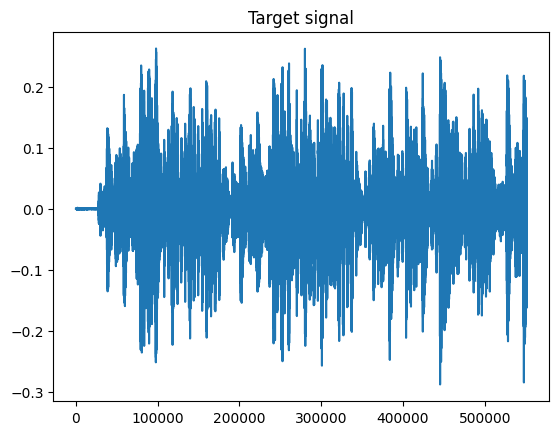

In [67]:
# Remember we set target the same as the content...
target_signal = audioDataHandler.reconstruct_signal_from_melspectrogram_segments(content_segments[:5])
plt.plot(target_signal)
plt.title('Target signal')
plt.show()
audioDataHandler.play_signal(target_signal)

Initialising NST parameters...

In [68]:
initial_learning_rate = 0.001
decay_steps  = 10
decay_rate = 1.0
content_layers = [list(outputs_dict.keys())[i] for i in [0, 2]]
style_layers = [list(outputs_dict.keys())[i] for i in [4, 6, 8, 10, 12, 14, 16]]
content_weight = float(100) / len(content_layers)
style_weight = float(10) / len(style_layers)

Running the training loop...

In [69]:
optimizer = keras.optimizers.SGD(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate))
# NOTE: Reassigning the optimizer resets its gradient

iterations = 100
for iteration in range(iterations):
    # Calculating total loss and gradient:
    loss, grads = get_loss_and_grads(content, style, target, content_layers, style_layers, feature_extractor, content_weight, style_weight)
    
    # Applying gradients:
    optimizer.apply_gradients([(grads, target)])

    # Displaying process:
    if iteration % 10 == 0 or (iteration == iterations - 1):
        #visualise(stitch_segments(target))
        print(f'i={iteration}\t | loss={float(loss)}')

i=0	 | loss=366597280.0
i=10	 | loss=252765568.0
i=20	 | loss=115575792.0
i=30	 | loss=48743056.0
i=40	 | loss=22454714.0
i=50	 | loss=12717768.0
i=60	 | loss=8773769.0
i=70	 | loss=6923303.5
i=80	 | loss=5887649.0
i=90	 | loss=5217270.0
i=99	 | loss=4782654.5


## Inspecting the output and comparing to content and style

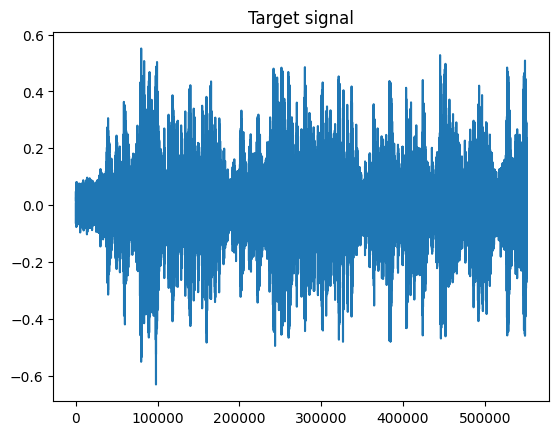

In [71]:
# Reshaping target for melspectrogram conversion (which was reshaped before NST by `get_data_for_nst`:
target_reshaped = np.reshape(target.numpy(), newshape=list(target.shape)[:-1])
# Getting the melspectrogram and signal and plotting the signal:
target_signal = audioDataHandler.reconstruct_signal_from_melspectrogram_segments(target_reshaped)
plt.plot(target_signal)
plt.title('Target signal')
plt.show()
audioDataHandler.play_signal(target_signal)

Content and style signals for reference...

In [ ]:
plt.plot(content_signal)
plt.title('Content signal')
plt.show()
audioDataHandler.play_signal(content_signal[:1000000])

plt.plot(style_signal)
plt.title('Style signal')
plt.show()
audioDataHandler.play_signal(style_signal[:1000000])